In [1]:
import pandas as pd
import os
import tensorflow as tf
import random
import numpy as np
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# setting seeds for reproducibility
seed = 1
os.environ['PYTHONHASHSEED']=str(seed)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
import pathlib
img_dir = 'C:\\Users\\adog1\\Documents\\Deep Learning\\Images'

total_files = 0
for root, dirs, files in os.walk(str(img_dir)):
    level = root.replace(str(img_dir), '').count(os.sep)
    indent = ' ' * 4 * (level)
    print(f'{indent}{os.path.basename(root)}/ ({len(files)} files)')
    total_files += len(files)
print(f'There are {total_files -1} images in this dataset')

Images/ (0 files)
    airport_inside/ (608 files)
    artstudio/ (140 files)
    auditorium/ (176 files)
    bakery/ (405 files)
    bar/ (604 files)
    bathroom/ (197 files)
    bedroom/ (662 files)
    bookstore/ (380 files)
    bowling/ (213 files)
    buffet/ (111 files)
    casino/ (515 files)
    children_room/ (112 files)
    church_inside/ (180 files)
    classroom/ (113 files)
    cloister/ (120 files)
    closet/ (135 files)
    clothingstore/ (106 files)
    computerroom/ (114 files)
    concert_hall/ (103 files)
    corridor/ (346 files)
    deli/ (258 files)
    dentaloffice/ (131 files)
    dining_room/ (274 files)
    elevator/ (101 files)
    fastfood_restaurant/ (116 files)
    florist/ (103 files)
    gameroom/ (127 files)
    garage/ (103 files)
    greenhouse/ (101 files)
    grocerystore/ (213 files)
    gym/ (231 files)
    hairsalon/ (239 files)
    hospitalroom/ (101 files)
    inside_bus/ (102 files)
    inside_subway/ (457 files)
    jewelleryshop/ (157 files

In [3]:
IndoorImage_dir = [ name for name in list(os.listdir(img_dir)) if os.path.isdir(os.path.join(img_dir, name)) ]
IndoorImage_dir.sort()   
print(f'\n The SORTED Indoor Image labels = {IndoorImage_dir}')
print(f'\nThere are {len(IndoorImage_dir)} classes of Indoor Images.') ### There are 38 (67) classes of Indoor Images.


 The SORTED Indoor Image labels = ['airport_inside', 'artstudio', 'auditorium', 'bakery', 'bar', 'bathroom', 'bedroom', 'bookstore', 'bowling', 'buffet', 'casino', 'children_room', 'church_inside', 'classroom', 'cloister', 'closet', 'clothingstore', 'computerroom', 'concert_hall', 'corridor', 'deli', 'dentaloffice', 'dining_room', 'elevator', 'fastfood_restaurant', 'florist', 'gameroom', 'garage', 'greenhouse', 'grocerystore', 'gym', 'hairsalon', 'hospitalroom', 'inside_bus', 'inside_subway', 'jewelleryshop', 'kindergarden', 'kitchen', 'laboratorywet', 'laundromat', 'library', 'livingroom', 'lobby', 'locker_room', 'mall', 'meeting_room', 'movietheater', 'museum', 'nursery', 'office', 'operating_room', 'pantry', 'poolinside', 'prisoncell', 'restaurant', 'restaurant_kitchen', 'shoeshop', 'stairscase', 'studiomusic', 'subway', 'toystore', 'trainstation', 'tv_studio', 'videostore', 'waitingroom', 'warehouse', 'winecellar']

There are 67 classes of Indoor Images.


### Removing Bad Images
I removed one bad image using the code below to identify files that had issues, and now the empty string of bad paths shows that all files should be good.

In [4]:
import glob
img_paths = glob.glob(os.path.join(img_dir,'*/*.*')) # assuming you point to the directory containing the label folders.

bad_paths = []

for image_path in img_paths:
    try:
      img_bytes = tf.io.read_file(image_path)
      decoded_img = tf.io.decode_image(img_bytes)
    except tf.errors.InvalidArgumentError as e:
      print(f"Found bad path {image_path}...{e}")
      bad_paths.append(image_path)

    #print(f"{image_path}: OK")

print("BAD PATHS:")
for bad_path in bad_paths:
    print(f"{bad_path}")

BAD PATHS:


### Preprocessing Images
The following three code cells use the preprocessing library of keras to reduce the dimensionality of the images and split them into training and validation sets.

In [5]:
batch_size = 8
img_height = 64
img_width = 64
split = 0.2

In [6]:
train_img = tf.keras.preprocessing.image_dataset_from_directory(
    img_dir,
    labels="inferred",
    label_mode="int",
    class_names=None,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    seed=1,
    validation_split=split,
    subset="training"
)

Found 15619 files belonging to 67 classes.
Using 12496 files for training.


In [7]:
val_img = tf.keras.preprocessing.image_dataset_from_directory(
    img_dir,
    labels="inferred",
    label_mode="int",
    class_names=None,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    seed=1,
    validation_split=split,
    subset="validation"
)

Found 15619 files belonging to 67 classes.
Using 3123 files for validation.


In [8]:
for image_batch, labels_batch in train_img:
  print(f'image_batch.shape = {image_batch.shape} \nlabels_batch.shape = {labels_batch.shape } ')
  break

image_batch.shape = (8, 64, 64, 3) 
labels_batch.shape = (8,) 


In [9]:
# Apply caching, shuffle, and prefetch 
# to help increase speed, reduce memory usage, and make processing more efficient

AUTOTUNE = tf.data.AUTOTUNE # Tune the value dynamically at runtime.

train_img = train_img.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_img = val_img.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255.0)

In [11]:
model = tf.keras.Sequential([
normalization_layer,
layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64,64,3)),
layers.MaxPooling2D(2, 2),
layers.Conv2D(64, (3, 3), activation='relu'),
layers.MaxPooling2D(2, 2),
layers.Conv2D(64, (3, 3), activation='relu'),
layers.Conv2D(64, (2, 2), activation='relu')
])

In [12]:
# Convert  feature matrix from 4D to 2D
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
# Add dropout layer
model.add(layers.Dropout(0.2))
# Final dense layer with a neuron for each possible outcome
model.add(layers.Dense(67))

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience= 5)
history = model.fit(train_img, epochs=100, 
                    validation_data=val_img, callbacks=[callback], verbose = 1)

Epoch 1/100
1562/1562 [==============================] - 67s 33ms/step - loss: 4.0372 - accuracy: 0.0443 - val_loss: 3.9949 - val_accuracy: 0.0503
Epoch 2/100
1562/1562 [==============================] - 49s 32ms/step - loss: 3.9022 - accuracy: 0.0699 - val_loss: 3.8027 - val_accuracy: 0.0730
Epoch 3/100
1562/1562 [==============================] - 49s 32ms/step - loss: 3.7740 - accuracy: 0.0780 - val_loss: 3.6868 - val_accuracy: 0.0945
Epoch 4/100
1562/1562 [==============================] - 48s 31ms/step - loss: 3.6760 - accuracy: 0.0952 - val_loss: 3.6224 - val_accuracy: 0.1098
Epoch 5/100
1562/1562 [==============================] - 45s 29ms/step - loss: 3.5959 - accuracy: 0.1085 - val_loss: 3.5456 - val_accuracy: 0.1146
Epoch 6/100
1562/1562 [==============================] - 44s 28ms/step - loss: 3.5134 - accuracy: 0.1224 - val_loss: 3.5024 - val_accuracy: 0.1246
Epoch 7/100
1562/1562 [==============================] - 44s 28ms/step - loss: 3.4360 - accuracy: 0.1385 - val_loss: 3

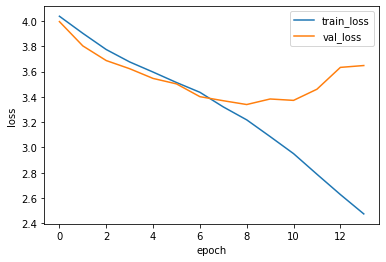

In [15]:
# Evaluating the model 
import seaborn as sns

train_history = pd.DataFrame(history.history)
train_history['epoch'] = history.epoch
# Plot train loss against validation loss
sns.lineplot(x='epoch', y ='loss', data =train_history)
sns.lineplot(x='epoch', y ='val_loss', data =train_history)
plt.legend(labels=['train_loss', 'val_loss'])

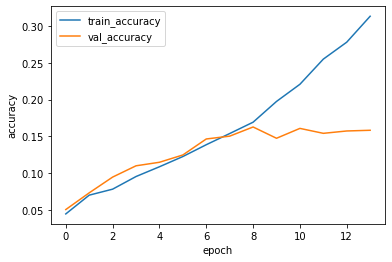

In [16]:
# Plot train accuracy against validation accuracy
sns.lineplot(x='epoch', y ='accuracy', data =train_history)
sns.lineplot(x='epoch', y ='val_accuracy', data =train_history)
plt.legend(labels=['train_accuracy', 'val_accuracy'])

In [17]:
data_aug = tf.keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", 
        input_shape=(64, 64, 3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.1,width_factor = 0.1 ),
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(0.1, 0.1))
  ]
)

In [18]:
model2 = tf.keras.Sequential([
# data augmentation
data_aug,
# data normalization
normalization_layer,
# building CNN
layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64,64,3)),
layers.MaxPooling2D(2, 2),
layers.Conv2D(64, (3, 3), activation='relu'),
layers.MaxPooling2D(2, 2),
layers.Conv2D(64, (3, 3), activation='relu'),
layers.Conv2D(64, (2, 2), activation='relu')
])
# Adding final layers
# Convert  feature matrix from 4D to 2D
model2.add(layers.Flatten())
model2.add(layers.Dense(64, activation='relu'))
# Add dropout layer
model2.add(layers.Dropout(0.2))
# Final dense layer with a neuron for each possible outcome
model2.add(layers.Dense(67))

In [19]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
history2 = model2.fit(train_img, epochs=100, 
                    validation_data=val_img, callbacks=[callback], verbose = 1)

Epoch 1/100
1562/1562 [==============================] - 96s 61ms/step - loss: 4.0347 - accuracy: 0.0430 - val_loss: 3.9943 - val_accuracy: 0.0442
Epoch 2/100
1562/1562 [==============================] - 96s 61ms/step - loss: 3.9723 - accuracy: 0.0531 - val_loss: 3.8879 - val_accuracy: 0.0663
Epoch 3/100
1562/1562 [==============================] - 512s 328ms/step - loss: 3.8991 - accuracy: 0.0612 - val_loss: 3.8542 - val_accuracy: 0.0612
Epoch 4/100
1562/1562 [==============================] - 92s 59ms/step - loss: 3.8707 - accuracy: 0.0613 - val_loss: 3.8791 - val_accuracy: 0.0557
Epoch 5/100
1562/1562 [==============================] - 87s 56ms/step - loss: 3.8424 - accuracy: 0.0680 - val_loss: 3.8933 - val_accuracy: 0.0576
Epoch 6/100
1562/1562 [==============================] - 93s 60ms/step - loss: 3.8200 - accuracy: 0.0695 - val_loss: 3.8404 - val_accuracy: 0.0669
Epoch 7/100
1562/1562 [==============================] - 92s 59ms/step - loss: 3.8003 - accuracy: 0.0731 - val_loss:

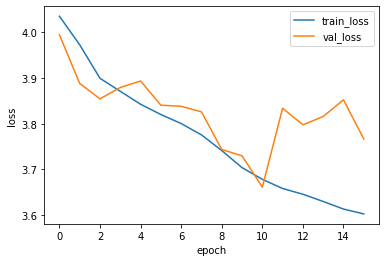

In [21]:
train_history = pd.DataFrame(history2.history)
train_history['epoch'] = history2.epoch
# Plot train loss against validation loss
sns.lineplot(x='epoch', y ='loss', data =train_history)
sns.lineplot(x='epoch', y ='val_loss', data =train_history)
plt.legend(labels=['train_loss', 'val_loss'])

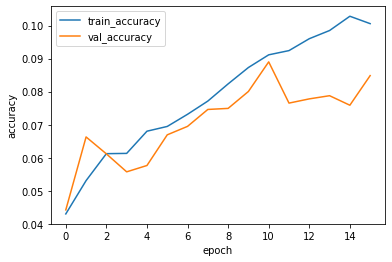

In [22]:
# Plot train accuracy against validation accuracy
sns.lineplot(x='epoch', y ='accuracy', data =train_history)
sns.lineplot(x='epoch', y ='val_accuracy', data =train_history)
plt.legend(labels=['train_accuracy', 'val_accuracy'])

### Making a Model with Transfer Learning

In [23]:
IMG_SHAPE = (64, 64, 3)

MobileNetV3Large_model = tf.keras.applications.MobileNetV3Large(input_shape = IMG_SHAPE,
                                               include_top=False, # Remove the fully-connected layer
                                               weights='imagenet') # Pre-training on ImageNet

In [24]:
MobileNetV3Large_model.trainable = False

In [25]:
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input

In [26]:
# setting the dataset to iterate batches as necessary
image_batch, label_batch = next(iter(train_img))
feature_batch = MobileNetV3Large_model(image_batch)
print(feature_batch.shape)

(8, 2, 2, 960)


In [27]:
# reshaping the features to a two-dimensional tensor
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(8, 960)


In [28]:
# flattening the features
global_average_layer = tf.keras.layers.Flatten()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(8, 3840)


In [29]:
# adding the prediction layer
prediction_layer = tf.keras.layers.Dense(67)
prediction_batch = prediction_layer(feature_batch_average)
print(f' The size of the predicted value for a given batch = {prediction_batch.shape}')

 The size of the predicted value for a given batch = (8, 67)


In [30]:
# making the model
inputs = tf.keras.Input(shape = IMG_SHAPE)
x = data_aug(inputs)
x = preprocess_input(x)
x = MobileNetV3Large_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
transfer_model = tf.keras.Model(inputs, outputs)

In [31]:
# compiling the model
transfer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience= 5)
history = transfer_model.fit(
  train_img,
  validation_data=val_img,
  epochs=100,
  callbacks=[callback], verbose = 1
)

Epoch 1/100
1562/1562 [==============================] - 94s 59ms/step - loss: 26.1152 - accuracy: 0.1156 - val_loss: 24.8978 - val_accuracy: 0.1934
Epoch 2/100
1562/1562 [==============================] - 101s 65ms/step - loss: 33.8924 - accuracy: 0.1559 - val_loss: 30.2910 - val_accuracy: 0.1896
Epoch 3/100
1562/1562 [==============================] - 84s 54ms/step - loss: 37.1943 - accuracy: 0.1723 - val_loss: 34.1260 - val_accuracy: 0.1924
Epoch 4/100
1562/1562 [==============================] - 89s 57ms/step - loss: 39.5656 - accuracy: 0.1825 - val_loss: 35.6068 - val_accuracy: 0.2075
Epoch 5/100
1562/1562 [==============================] - 89s 57ms/step - loss: 40.8982 - accuracy: 0.1894 - val_loss: 37.2701 - val_accuracy: 0.1963
Epoch 6/100
1562/1562 [==============================] - 90s 58ms/step - loss: 41.9570 - accuracy: 0.1986 - val_loss: 39.3482 - val_accuracy: 0.2027
Epoch 7/100
1562/1562 [==============================] - 94s 60ms/step - loss: 43.0192 - accuracy: 0.2008

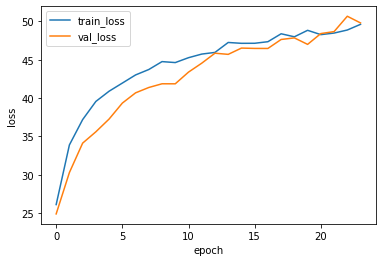

In [33]:
train_history = pd.DataFrame(history.history)
train_history['epoch'] = history.epoch
# Plot train loss against validation loss
sns.lineplot(x='epoch', y ='loss', data =train_history)
sns.lineplot(x='epoch', y ='val_loss', data =train_history)
plt.legend(labels=['train_loss', 'val_loss'])

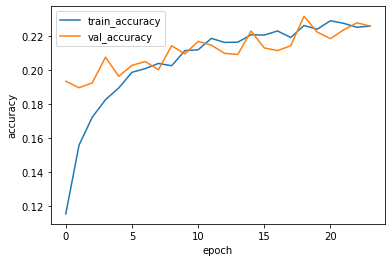

In [34]:
# Plot train accuracy against validation accuracy
sns.lineplot(x='epoch', y ='accuracy', data =train_history)
sns.lineplot(x='epoch', y ='val_accuracy', data =train_history)
plt.legend(labels=['train_accuracy', 'val_accuracy'])

### Model Comparison, Which Model to Pick
The transfer model seems to have some layer that is affecting how loss is calculated, even though all three models specified a loss function of sparse categorical cross-entropy when compiled. However, despite the oddity of how the transfer model is calculating loss, the validation accuracy doesn't lie. The standard, basic convolutional network performs better than the data augmented network, which is odd. However, the transfer learning model is much more effective than either, especially in how it extrapolates to validation data, which we see when the loss and the accuracy for training versus validation data track along with each other.

### Building RNN Models

In [35]:
import pandas as pd
from sklearn import preprocessing
import re
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

data_path = "C:\\Users\\adog1\\Documents\\Deep Learning\\training.1600000.processed.noemoticon.csv"
sentiment_tweets = pd.read_csv(data_path, encoding='iso-8859-1', names=['sentiment', 'id', 'date', 'flag', 'user', 'text'])
sentiment_tweets.head()

,sentiment,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [36]:
le = preprocessing.LabelEncoder()
sentiment_tweets['label'] = le.fit_transform(sentiment_tweets['sentiment'])
sentiment_tweets.label.value_counts()

0    800000
1    800000
Name: label, dtype: int64

In [37]:
# Remove all special characters, punctuation and spaces
sentiment_tweets['text'] = sentiment_tweets['text'].apply(lambda x: re.sub(r'[^A-Za-z0-9]+',' ',x))
# Remove length <=2
sentiment_tweets['text'] = sentiment_tweets['text'].apply(lambda x: re.sub(r'\b[a-zA-Z]{1,2}\b', '', x))

sentiment_tweets.head()

,sentiment,id,date,flag,user,text,label
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,switchfoot http twitpic com 2y1zl Awww that ...,0
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset that can update his Facebook texting...,0
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,Kenichan dived many times for the ball Manag...,0
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feels itchy and like its fire,0
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,nationwideclass not behaving all mad wh...,0


In [38]:
X = sentiment_tweets['text'].values
y = sentiment_tweets['label'].values
X_train, X_hold, y_train, y_hold = train_test_split(X, y, stratify=y, test_size=0.4)
X_val, X_test, y_val, y_test = train_test_split(X_hold, y_hold, stratify=y_hold, test_size=0.5)

In [39]:
# Specify the vocab size
VOCAB_SIZE = 1000
# Perform text vectorization
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)

# Fits the state of the preprocessing layer to the dataset.
encoder.adapt(X_train)

### First Model
This model will include a GRU layer, but not LSTM layer.

In [40]:
model1 = tf.keras.Sequential([
    # Convert review text to indices
    encoder, 
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.GRU(128, return_sequences=False),
    # Binary classifier
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3)
])

### Second Model
This model will include an LSTM later, but not a GRU layer.

In [41]:
model2 = tf.keras.Sequential([
    # Convert review text to indices
    encoder, 
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    # Binary classifier
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3)
])

### Third Model
This model will include both a GRU and an LSTM layer.

In [42]:
model3 = tf.keras.Sequential([
    # Convert review text to indices
    encoder, 
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    # 
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    # Binary classifier
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3)
])

In [43]:
print(f'X_train size  ={X_train.shape}; y_train size  ={y_train.shape}')
print(f'X_val size  ={X_val.shape}; y_val size  ={y_val.shape}')

X_train size  =(960000,); y_train size  =(960000,)
X_val size  =(320000,); y_val size  =(320000,)


### Model 1 Results

In [44]:
# compiling model
model1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [45]:
history1 = model1.fit(x=X_train,y=y_train,epochs=3,
          validation_data=(X_val,y_val), batch_size=32, verbose= 1
          )

Epoch 1/3
30000/30000 [==============================] - 586s 19ms/step - loss: 0.4971 - accuracy: 0.7543 - val_loss: 0.4752 - val_accuracy: 0.7681
Epoch 2/3
30000/30000 [==============================] - 757s 25ms/step - loss: 0.4698 - accuracy: 0.7711 - val_loss: 0.4657 - val_accuracy: 0.7727
Epoch 3/3
30000/30000 [==============================] - 775s 26ms/step - loss: 0.4617 - accuracy: 0.7762 - val_loss: 0.4598 - val_accuracy: 0.7775


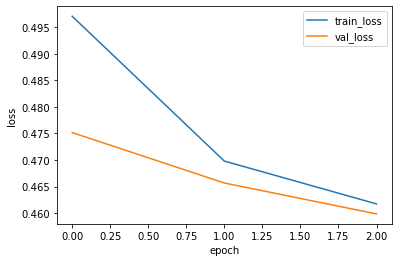

In [46]:
# Plotting training versus validation loss
train_history = pd.DataFrame(history1.history)
train_history['epoch'] = history1.epoch
sns.lineplot(x='epoch', y ='loss', data =train_history)
sns.lineplot(x='epoch', y ='val_loss', data =train_history)
plt.legend(labels=['train_loss', 'val_loss'])

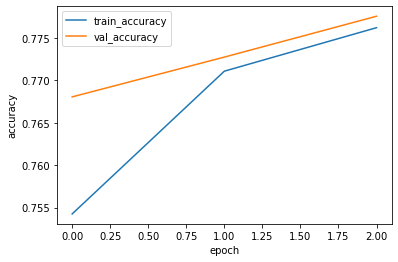

In [47]:
# Plotting training versus validation accuracy
sns.lineplot(x='epoch', y ='accuracy', data =train_history)
sns.lineplot(x='epoch', y ='val_accuracy', data =train_history)
plt.legend(labels=['train_accuracy', 'val_accuracy'])

### Model 2 Results

In [48]:
# compiling model
model2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [49]:
history2 = model2.fit(x=X_train,y=y_train,batch_size= 32,epochs=3,
          validation_data=(X_val,y_val), verbose= 1
          )

Epoch 1/3
30000/30000 [==============================] - 1010s 34ms/step - loss: 0.4957 - accuracy: 0.7562 - val_loss: 0.4753 - val_accuracy: 0.7682
Epoch 2/3
30000/30000 [==============================] - 72394s 2s/step - loss: 0.4689 - accuracy: 0.7720 - val_loss: 0.4651 - val_accuracy: 0.7736
Epoch 3/3
30000/30000 [==============================] - 1023s 34ms/step - loss: 0.4594 - accuracy: 0.7781 - val_loss: 0.4577 - val_accuracy: 0.7794


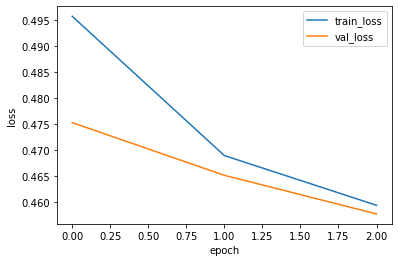

In [50]:
# Plotting training versus validation loss
train_history = pd.DataFrame(history2.history)
train_history['epoch'] = history2.epoch
sns.lineplot(x='epoch', y ='loss', data =train_history)
sns.lineplot(x='epoch', y ='val_loss', data =train_history)
plt.legend(labels=['train_loss', 'val_loss'])

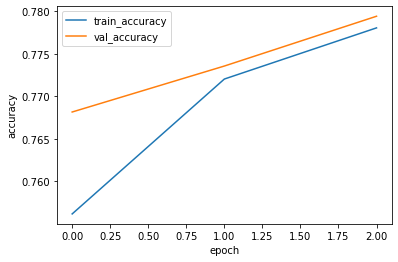

In [51]:
# Plotting training versus validation accuracy
sns.lineplot(x='epoch', y ='accuracy', data =train_history)
sns.lineplot(x='epoch', y ='val_accuracy', data =train_history)
plt.legend(labels=['train_accuracy', 'val_accuracy'])

### Model 3 Results

In [52]:
# compiling model
model3.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [53]:
history3 = model3.fit(x=X_train,y=y_train,batch_size= 32,epochs=3,
          validation_data=(X_val,y_val), verbose= 1
          )

Epoch 1/3
30000/30000 [==============================] - 10932s 364ms/step - loss: 0.4942 - accuracy: 0.7567 - val_loss: 0.4758 - val_accuracy: 0.7687
Epoch 2/3
30000/30000 [==============================] - 43056s 1s/step - loss: 0.4694 - accuracy: 0.7722 - val_loss: 0.4640 - val_accuracy: 0.7739
Epoch 3/3
30000/30000 [==============================] - 84630s 3s/step - loss: 0.4590 - accuracy: 0.7784 - val_loss: 0.4571 - val_accuracy: 0.7795


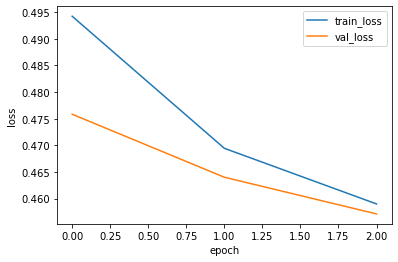

In [54]:
# Plotting training versus validation loss
train_history = pd.DataFrame(history3.history)
train_history['epoch'] = history3.epoch
sns.lineplot(x='epoch', y ='loss', data =train_history)
sns.lineplot(x='epoch', y ='val_loss', data =train_history)
plt.legend(labels=['train_loss', 'val_loss'])

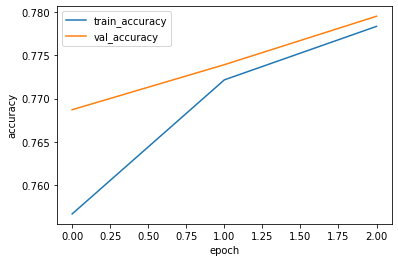

In [55]:
# Plotting training versus validation accuracy
sns.lineplot(x='epoch', y ='accuracy', data =train_history)
sns.lineplot(x='epoch', y ='val_accuracy', data =train_history)
plt.legend(labels=['train_accuracy', 'val_accuracy'])

### Model Analysis
Looking at the validation data for these models, the third model achieves the highest validation accuracy and the lowest loss, although it is very close with only a few epochs. Unfortunately, due to the massive dataset, having further epochs run is somewhat time prohibitive, so my approach would probably be to use the third model with more epochs based on this data, as we can see that it is still underfit, with validation loss still decreasing and validation accuracy still increasing.